# Model Continuation:

In this notebook I'll do an end-to-end model using all features we've narrowed down to.  I will check multicollinearity and all linear regression assumptions.

First, let's do our imports and get our dataset:

In [29]:
# imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

In [30]:
df = pd.read_csv('../data/our_dataframe.csv')

In [31]:
# preview data:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,zipcode,sqfttotbasement,sqftfinbasement,sqftopenporch,sqftenclosedporch,...,lakewashington,lakesammamish,smalllakerivercreek,otherview,wfntlocation,trafficnoise,airportnoise,powerlines,othernuisances,adjacentgreenbelt
0,1910000,3990,1952,2019,6,98125,1360,1360,110,0,...,1,0,0,0,0,0,0,N,N,N
1,1089950,3920,2018,0,5,98028.0,930,930,550,0,...,0,0,0,0,0,0,0,N,N,N
2,412500,2280,1958,0,4,98056,1140,1140,0,0,...,0,0,0,0,0,1,0,N,N,N
3,541000,1030,1965,0,3,98052,0,0,210,0,...,0,0,0,0,0,0,0,N,N,N
4,1020000,2410,1939,0,3,98144,1070,1070,0,0,...,4,0,0,0,0,1,0,N,N,N


Let's visualise our Sale Price data first since it is our target variable:

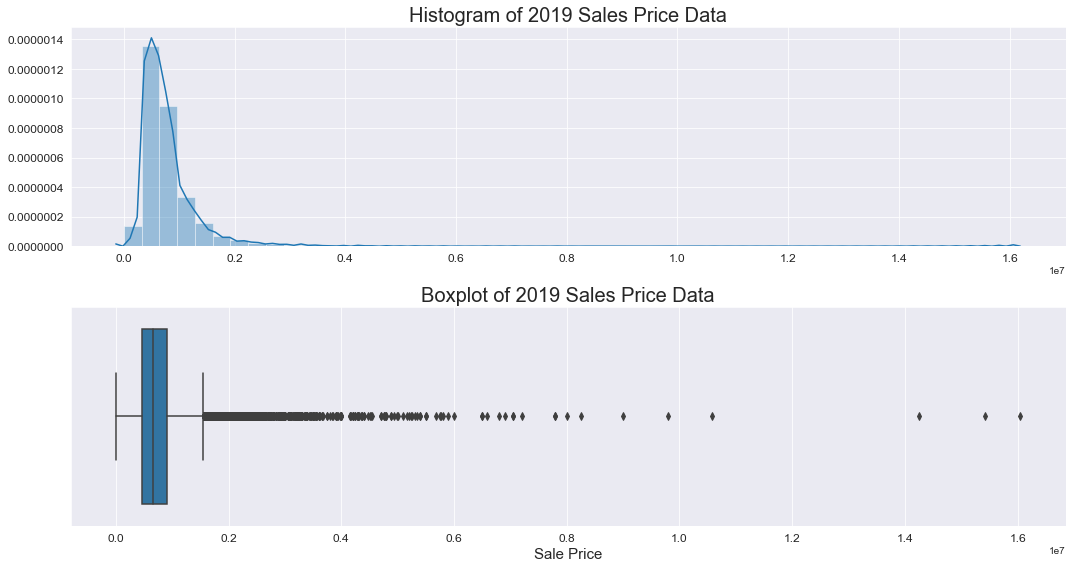

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].set_title('Histogram of 2019 Sales Price Data', fontsize = 20)
sns.distplot(df.saleprice, ax = ax[0], axlabel = "")
ax[1].set_title('Boxplot of 2019 Sales Price Data', fontsize = 20)
sns.boxplot(df.saleprice, ax= ax[1])
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)
plt.xlabel('Sale Price', fontsize = 15)
plt.tight_layout()

### Outliers

There appears to be many outliers.  We will create a z-score column for the sale price and drop any values that are more than 3 standard deviations away from the mean sale price:

In [6]:
# create mean and sd variables
mean_saleprice = df['saleprice'].mean()
sd_saleprice = df['saleprice'].std()

# create z-score column
df['z_saleprice'] = (df['saleprice'] - mean_saleprice) / sd_saleprice

In [7]:
# now, update dataframe with only values within 3 standard deviations of the mean:
df = df[(df['z_saleprice'] <= 3) & (df['z_saleprice'] >= -3)]

Now let's see if eliminating the outliers changed our data by much:

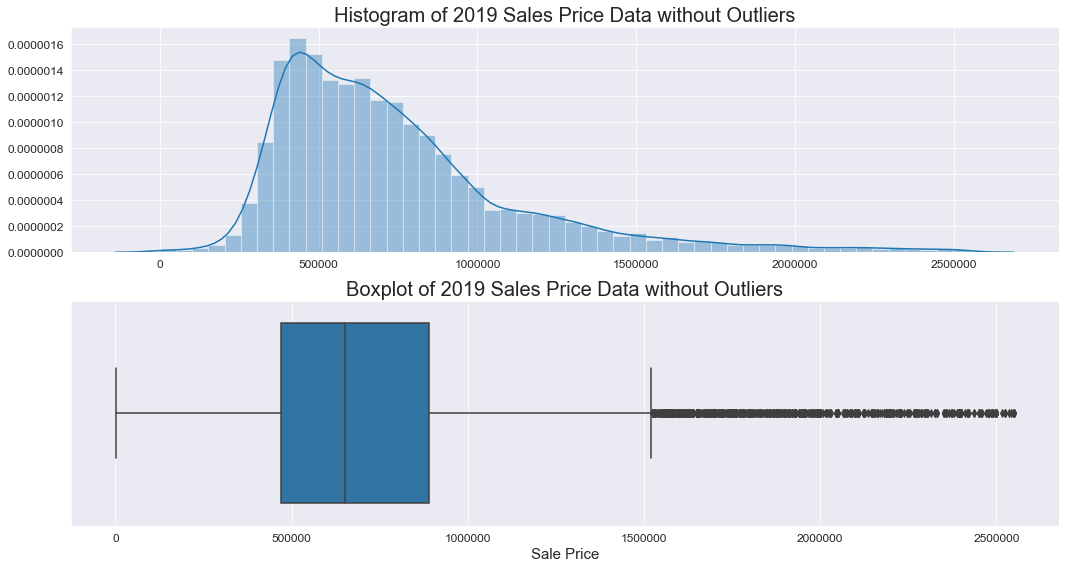

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].set_title('Histogram of 2019 Sales Price Data without Outliers', fontsize = 20)
sns.distplot(df.saleprice, ax = ax[0], axlabel = "")
ax[1].set_title('Boxplot of 2019 Sales Price Data without Outliers', fontsize = 20)
sns.boxplot(df.saleprice, ax= ax[1])
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)
plt.xlabel('Sale Price', fontsize = 15)
plt.tight_layout()

### Summary statistics:

We can see the summary statistics for our data as follows:

In [11]:
df.describe()

,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,sqfttotbasement,sqftfinbasement,sqftopenporch,sqftenclosedporch,sqftdeck,...,seattleskyline,pugetsound,lakewashington,lakesammamish,smalllakerivercreek,otherview,wfntlocation,trafficnoise,airportnoise,z_saleprice
count,1.799000e+04,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,...,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.000000,17990.0,17990.000000
mean,7.452165e+05,2106.703669,1974.592107,95.942412,3.422290,471.249528,294.081768,69.566203,5.363924,133.856142,...,0.019233,0.055309,0.044302,0.009783,0.020789,0.012729,0.077877,0.198722,0.0,-0.084547
std,3.909353e+05,891.843067,30.270575,427.439970,0.912567,566.925795,437.641512,142.951177,36.385427,208.677926,...,0.226803,0.376056,0.332909,0.157507,0.248876,0.178331,0.758955,0.543334,0.0,0.666861
min,1.000000e+01,290.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.355728
25%,4.690000e+05,1450.000000,1954.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.555720
50%,6.500000e+05,1960.000000,1977.500000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.246968
75%,8.899970e+05,2590.000000,2001.000000,0.000000,4.000000,940.000000,560.000000,100.000000,0.000000,210.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.162421
max,2.550000e+06,10910.000000,2020.000000,2020.000000,13.000000,5060.000000,4590.000000,11570.000000,1840.000000,2250.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,9.000000,3.000000,0.0,2.994071


The mean and max values of `saleprice` seem reasonable for Seattle's real estate market so we continue with this data.

## Visualising numeric values of the dataset:

We now plot histograms of all the numeric variables in the dataset:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ca14730>,
      dtype=object)

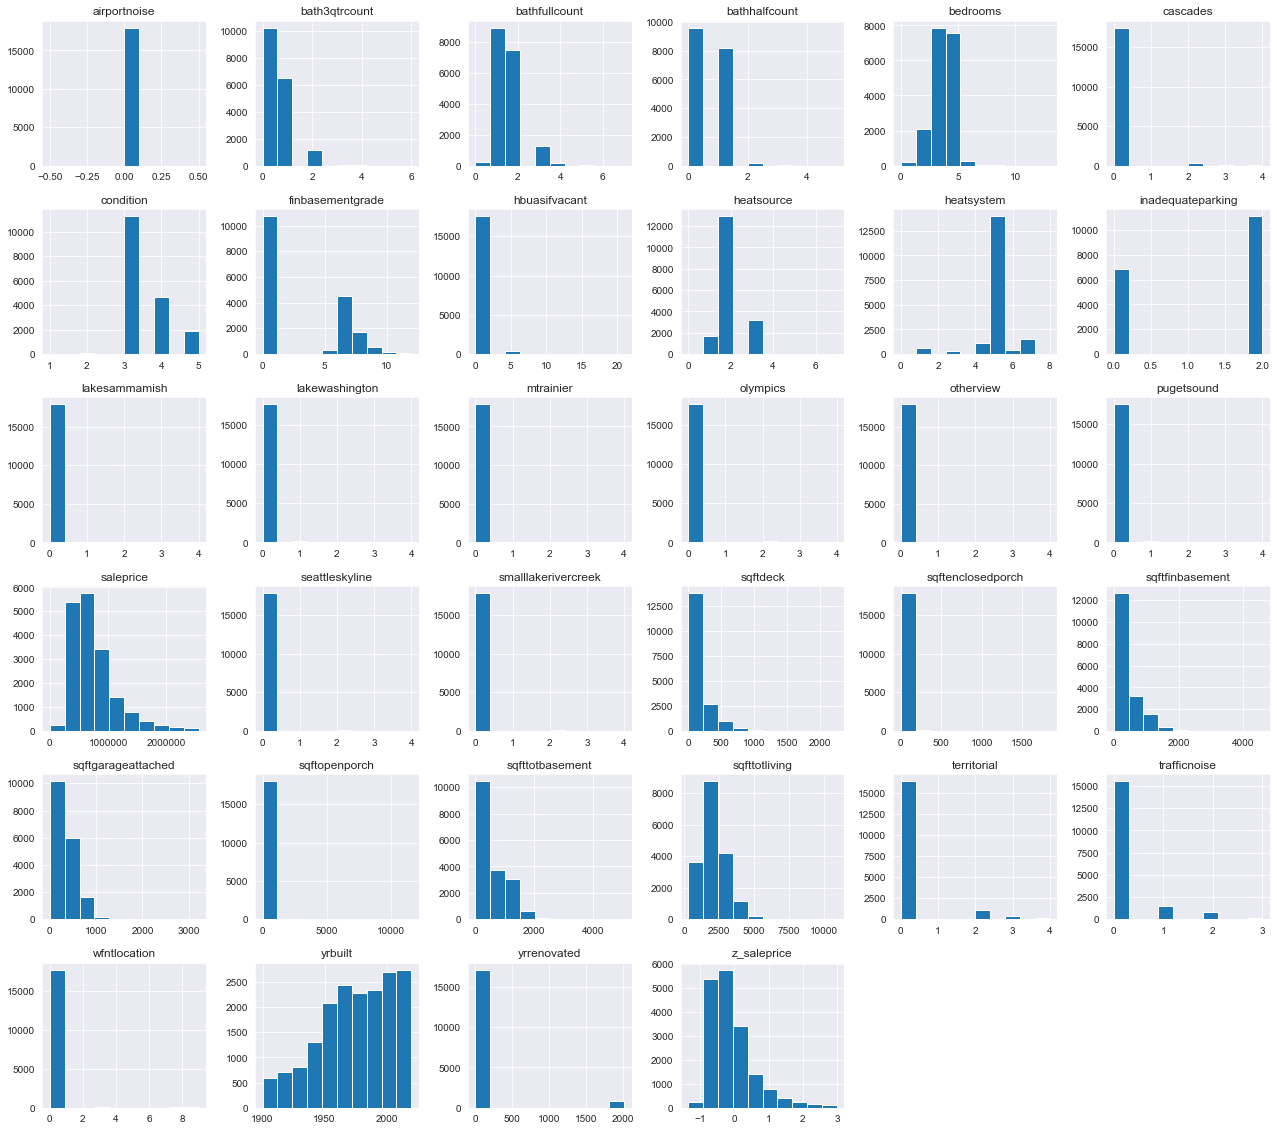

In [12]:
df.hist(figsize = (22, 20))

We have a lot of categorical variables so we might want to think about the validity of some of these plots. 

## Check Multicolinearity

Let's get an idea of what values are correlated:

In [21]:
corr = df.corr()
corr

,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,sqfttotbasement,sqftfinbasement,sqftopenporch,sqftenclosedporch,sqftdeck,...,seattleskyline,pugetsound,lakewashington,lakesammamish,smalllakerivercreek,otherview,wfntlocation,trafficnoise,airportnoise,z_saleprice
saleprice,1.000000,0.636020,0.095832,0.102641,0.316679,0.243885,0.255762,0.239205,0.013716,0.216612,...,0.134205,0.126802,0.200085,0.127037,0.038560,0.062384,0.091410,-0.001625,NaN,1.000000
sqfttotliving,0.636020,1.000000,0.348099,0.034791,0.625069,0.272973,0.386867,0.323307,-0.003961,0.227035,...,0.060583,0.081984,0.111753,0.082483,0.021505,0.054779,0.038201,-0.062093,NaN,0.636020
yrbuilt,0.095832,0.348099,1.000000,-0.250835,0.198852,-0.238588,-0.125384,0.144286,-0.081098,0.040852,...,-0.019505,-0.067977,-0.059211,0.012496,-0.008364,0.016707,-0.013014,-0.099737,NaN,0.095832
yrrenovated,0.102641,0.034791,-0.250835,1.000000,0.011236,0.062340,0.079896,0.016072,0.019389,0.052740,...,0.014267,0.069757,0.067789,0.033791,0.015731,-0.001396,0.041231,0.039887,NaN,0.102641
bedrooms,0.316679,0.625069,0.198852,0.011236,1.000000,0.210262,0.289720,0.157804,-0.017228,0.090695,...,0.013668,-0.012988,0.039603,0.020759,-0.026174,0.022646,-0.032155,-0.044586,NaN,0.316679
sqfttotbasement,0.243885,0.272973,-0.238588,0.062340,0.210262,1.000000,0.848621,-0.040744,0.015085,0.259692,...,0.092017,0.135838,0.152124,0.054503,0.011851,0.029177,-0.001172,0.064273,NaN,0.243885
sqftfinbasement,0.255762,0.386867,-0.125384,0.079896,0.289720,0.848621,1.000000,-0.020258,0.005890,0.283568,...,0.093392,0.137918,0.150352,0.069654,0.015273,0.035212,0.007847,0.037787,NaN,0.255762
sqftopenporch,0.239205,0.323307,0.144286,0.016072,0.157804,-0.040744,-0.020258,1.000000,-0.008582,-0.025175,...,-0.011745,0.004625,0.016610,0.007803,0.051244,0.025141,0.096902,-0.027476,NaN,0.239205
sqftenclosedporch,0.013716,-0.003961,-0.081098,0.019389,-0.017228,0.015085,0.005890,-0.008582,1.000000,0.013949,...,0.009660,-0.000086,0.004428,0.003065,0.005180,-0.000414,-0.000320,0.027787,NaN,0.013716
sqftdeck,0.216612,0.227035,0.040852,0.052740,0.090695,0.259692,0.283568,-0.025175,0.013949,1.000000,...,0.088443,0.138199,0.127501,0.073573,0.080721,0.037776,0.090193,-0.005783,NaN,0.216612


This might be more easily viewed as a heatmap

In [16]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

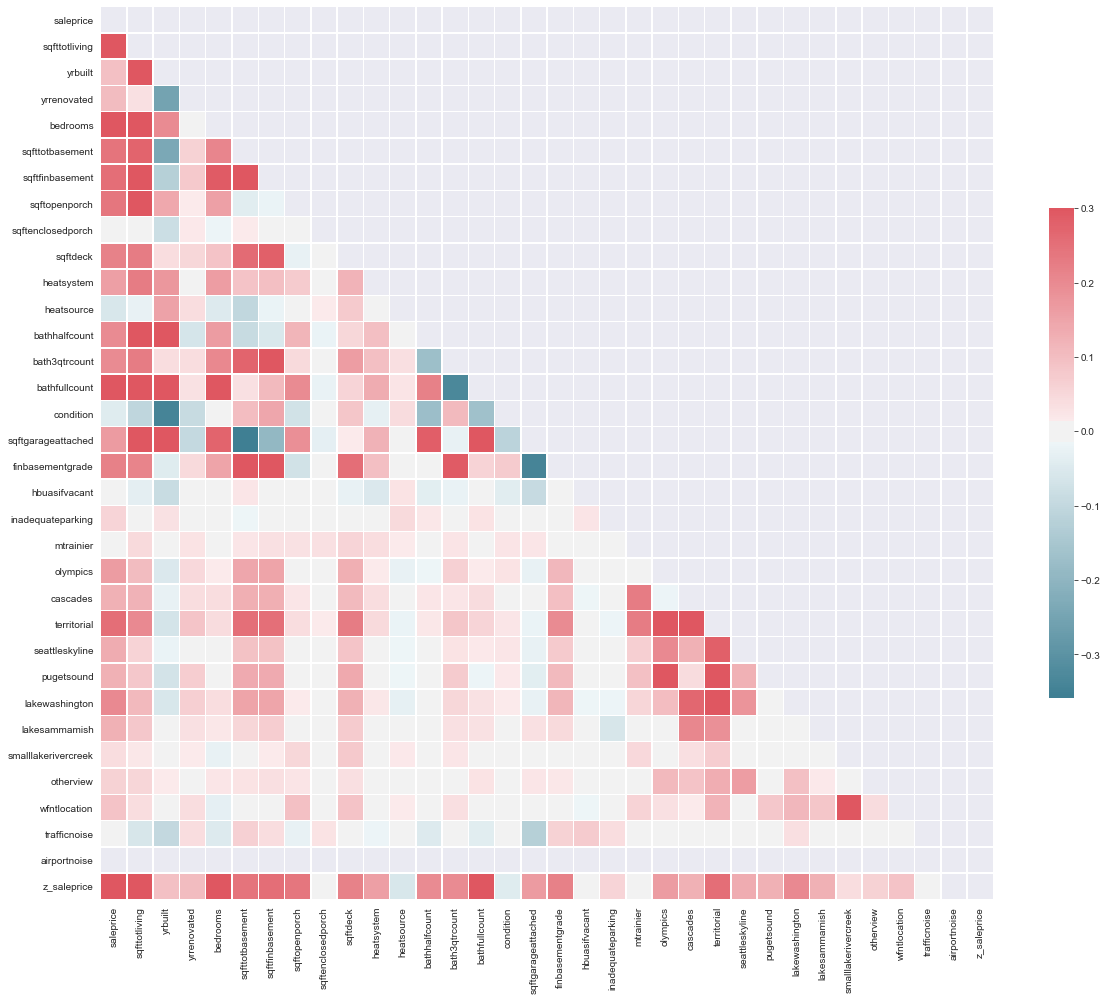

In [20]:
f, ax = plt.subplots(figsize = (20, 18))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, 
            center = 0, square = True, linewidths = 0.5, 
            cbar_kws = {'shrink': 0.5})

The light, white values so variables that aren't correlated together and so will help us meet the linearity assumption.  Let's first just start with a model of everything:

## First Shitty Model:

In [63]:
outcome = 'saleprice'
x_cols = list(df.columns)
x_cols.remove(outcome)
x_cols.remove('z_saleprice')

In [64]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     362.8
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:07:49   Log-Likelihood:            -2.1041e+05
No. Observations:               15658   AIC:                         4.212e+05
Df Residuals:                   15473   BIC:                         4.226e+05
Df Model:                         184                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.005e+06   2.43e+05      4.139      0.000    5.29e+05    1.48e+06
zipcode[T.98]             5.823e+05   2.36e+05      2.463      0.014    1.19e+05    1.05e+06
zipcode[T.98001]         -3.799e+05   1.67e+05     -2.272      0.023   -7.08e+05   -5.21e+04
zipcode[T.98002]         -3.757e+05   1.67e+05     -2.244      0.025   -7.04e+05   -4.75e+04
zipcode[T.98003]           -3.8e+05   1.67e+05     -2.272      0.023   -7.08e+05   -5.21e+04
zipcode[T.98004]          6.863e+05   1.68e+05      4.096      0.000    3.58e+05    1.01e+06
zipcode[T.98005]          3.281e+05   1.68e+05      1.955      0.051    -837.951    6.57e+05
zipcode[T.98006]          9.059e+04   1.67e+05      0.542      0.588   -2.37e+05    4.18e+05
zipcode[T.98007]          7.994e+04   1.68e+05      0.476      0.634   -2.49e+05    4.09e+05
zipcode[T.98008]          5.104e+04   1.67e+05      0.305      0.760   -2.77e+05    3.79e+05
zipcode[T.98010]         -3.475e+05   1.69e+05     -2.058      0.040   -6.78e+05   -1.66e+04
zipcode[T.98011]          -1.56e+05   1.68e+05     -0.931      0.352   -4.84e+05    1.72e+05
zipcode[T.98014]         -1.942e+05   1.68e+05     -1.155      0.248   -5.24e+05    1.35e+05
zipcode[T.98019]         -2.306e+05   1.68e+05     -1.375      0.169   -5.59e+05    9.82e+04
zipcode[T.98022]         -3.843e+05   1.67e+05     -2.295      0.022   -7.12e+05   -5.61e+04
zipcode[T.98023]         -4.101e+05   1.67e+05     -2.454      0.014   -7.38e+05   -8.25e+04
zipcode[T.98024]           -1.2e+05   1.69e+05     -0.711      0.477   -4.51e+05    2.11e+05
zipcode[T.98027]         -1.055e+05   1.67e+05     -0.630      0.529   -4.34e+05    2.23e+05
zipcode[T.98028]         -1.893e+05   1.67e+05     -1.131      0.258   -5.17e+05    1.39e+05
zipcode[T.98029]         -2.661e+04   1.67e+05     -0.159      0.874   -3.55e+05    3.02e+05
zipcode[T.98030]         -3.729e+05   1.67e+05     -2.227      0.026   -7.01e+05   -4.47e+04
zipcode[T.98031]         -3.424e+05   1.67e+05     -2.047      0.041    -6.7e+05   -1.45e+04
zipcode[T.98032]         -3.688e+05   1.68e+05     -2.199      0.028   -6.98e+05   -4.01e+04
zipcode[T.98033]          2.496e+05   1.67e+05      1.492      0.136   -7.83e+04    5.78e+05
zipcode[T.98034]         -6.216e+04   1.67e+05     -0.372      0.710    -3.9e+05    2.66e+05
zipcode[T.98038]         -3.326e+05   1.67e+05     -1.989      0.047    -6.6e+05   -4862.379
zipcode[T.98039]          1.003e+06   1.73e+05      5.814      0.000    6.65e+05    1.34e+06
zipcode[T.98040]          4.094e+05   1.67e+05      2.445      0.014    8.12e+04    7.38e+05
zipcode[T.98042]         -3.689e+05   1.67e+05     -2.207      0.027   -6.97e+05   -4.13e+04
zipcode[T.98045]         -1.966e+05   1.67e+05     -1.174      0.240   -5.25e+05    1.32e+05
zipcode[T.9804

I noticed above that `zipcode` was not formatted correctly so let's do some formatting now:

In [31]:
df['zipcode']

0          98125
1        98028.0
2          98056
3          98052
4          98144
          ...   
18288      98072
18289        NaN
18290      98058
18291      98146
18292      98112
Name: zipcode, Length: 17990, dtype: object

In [32]:
df.columns

Index(['saleprice', 'sqfttotliving', 'yrbuilt', 'yrrenovated', 'bedrooms',
       'zipcode', 'sqfttotbasement', 'sqftfinbasement', 'sqftopenporch',
       'sqftenclosedporch', 'sqftdeck', 'heatsystem', 'heatsource',
       'bathhalfcount', 'bath3qtrcount', 'bathfullcount', 'condition',
       'viewutilization', 'sqftgarageattached', 'daylightbasement',
       'finbasementgrade', 'hbuasifvacant', 'inadequateparking', 'mtrainier',
       'olympics', 'cascades', 'territorial', 'seattleskyline', 'pugetsound',
       'lakewashington', 'lakesammamish', 'smalllakerivercreek', 'otherview',
       'wfntlocation', 'trafficnoise', 'airportnoise', 'powerlines',
       'othernuisances', 'adjacentgreenbelt', 'z_saleprice'],
      dtype='object')

In [33]:
df['zipcode'].unique()

array(['98125', '98028.0', '98056', '98052', '98144', '98117', '98198',
       '98004', '98040', '98115', '98108', '98126', nan, '98055', '98136',
       '98116', '98106', '98072', '98092', '98023', '98029', '98077',
       '98032', '98107', '98003', '98058', '98168', '98070.0', '98059',
       '98006', '98001', '98042', '98155', '98030', '98027', '98065',
       '98118', '98168.0', '98002', '98199', '98122', '98038', '98034',
       '98102', '98053', '98008', '98108.0', '98053.0', '98105',
       '98006.0', '98112', '98178', '98103', '98075', '98033', '98148',
       '98031', '98024', '98045', '98022', '98109', '98166', '98199.0',
       '98074.0', '98133', '98119', '98126.0', '98070', '98019', '98146',
       '98007', '98007.0', '98056.0', '98134', '98023.0', '98028',
       '98125.0', '98188', '98074', '98177', '98050', '98047', '98072.0',
       '98008.0', '98002.0', '98051', '98155.0', '98055.0', '98005',
       '98014', '98119.0', '98058.0', '98032.0', '98105.0', '98042.0',
     

In [36]:
df['zipcode'] = df['zipcode'].str[:5]
df['zipcode'].unique()

array(['98125', '98028', '98056', '98052', '98144', '98117', '98198',
       '98004', '98040', '98115', '98108', '98126', nan, '98055', '98136',
       '98116', '98106', '98072', '98092', '98023', '98029', '98077',
       '98032', '98107', '98003', '98058', '98168', '98070', '98059',
       '98006', '98001', '98042', '98155', '98030', '98027', '98065',
       '98118', '98002', '98199', '98122', '98038', '98034', '98102',
       '98053', '98008', '98105', '98112', '98178', '98103', '98075',
       '98033', '98148', '98031', '98024', '98045', '98022', '98109',
       '98166', '98074', '98133', '98119', '98019', '98146', '98007',
       '98134', '98188', '98177', '98050', '98047', '98051', '98005',
       '98014', '98011', '98354', '98010', '98039', '98224', '98288',
       '98079', '98113', '98057', '98', '91844', '98812'], dtype=object)

## Dealing with categorical variables:

It appears above that some of our categorical variables which are coded as `ints` are not being treated appropriately.  We should change them into strings so that our model knows they're categorical variables.

In [42]:
categorical_features = ['heatsystem', 'heatsource', 'condition', 'viewutilization', 'daylightbasement', 
 'mtrainier', 'olympics', 'cascades', 'territorial', 'seattleskyline', 'pugetsound', 
 'lakewashington', 'lakesammamish', 'smalllakerivercreek', 'otherview', 'wfntlocation', 
 'trafficnoise', 'powerlines', 'othernuisances', 'adjacentgreenbelt', 'finbasementgrade', 'inadequateparking', 'airportnoise', 'hbuasifvacant']

In [43]:
for feature in categorical_features:
    df[feature] = df[feature].astype(str)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17990 entries, 0 to 18292
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   saleprice            17990 non-null  int64  
 1   sqfttotliving        17990 non-null  int64  
 2   yrbuilt              17990 non-null  int64  
 3   yrrenovated          17990 non-null  int64  
 4   bedrooms             17990 non-null  int64  
 5   zipcode              15658 non-null  object 
 6   sqfttotbasement      17990 non-null  int64  
 7   sqftfinbasement      17990 non-null  int64  
 8   sqftopenporch        17990 non-null  int64  
 9   sqftenclosedporch    17990 non-null  int64  
 10  sqftdeck             17990 non-null  int64  
 11  heatsystem           17990 non-null  object 
 12  heatsource           17990 non-null  object 
 13  bathhalfcount        17990 non-null  int64  
 14  bath3qtrcount        17990 non-null  int64  
 15  bathfullcount        17990 non-null 

**Does it make more sense for zipcode to be an int??**

Now, let's try viewing out variable histograms and heatmap to see if that makes any difference:

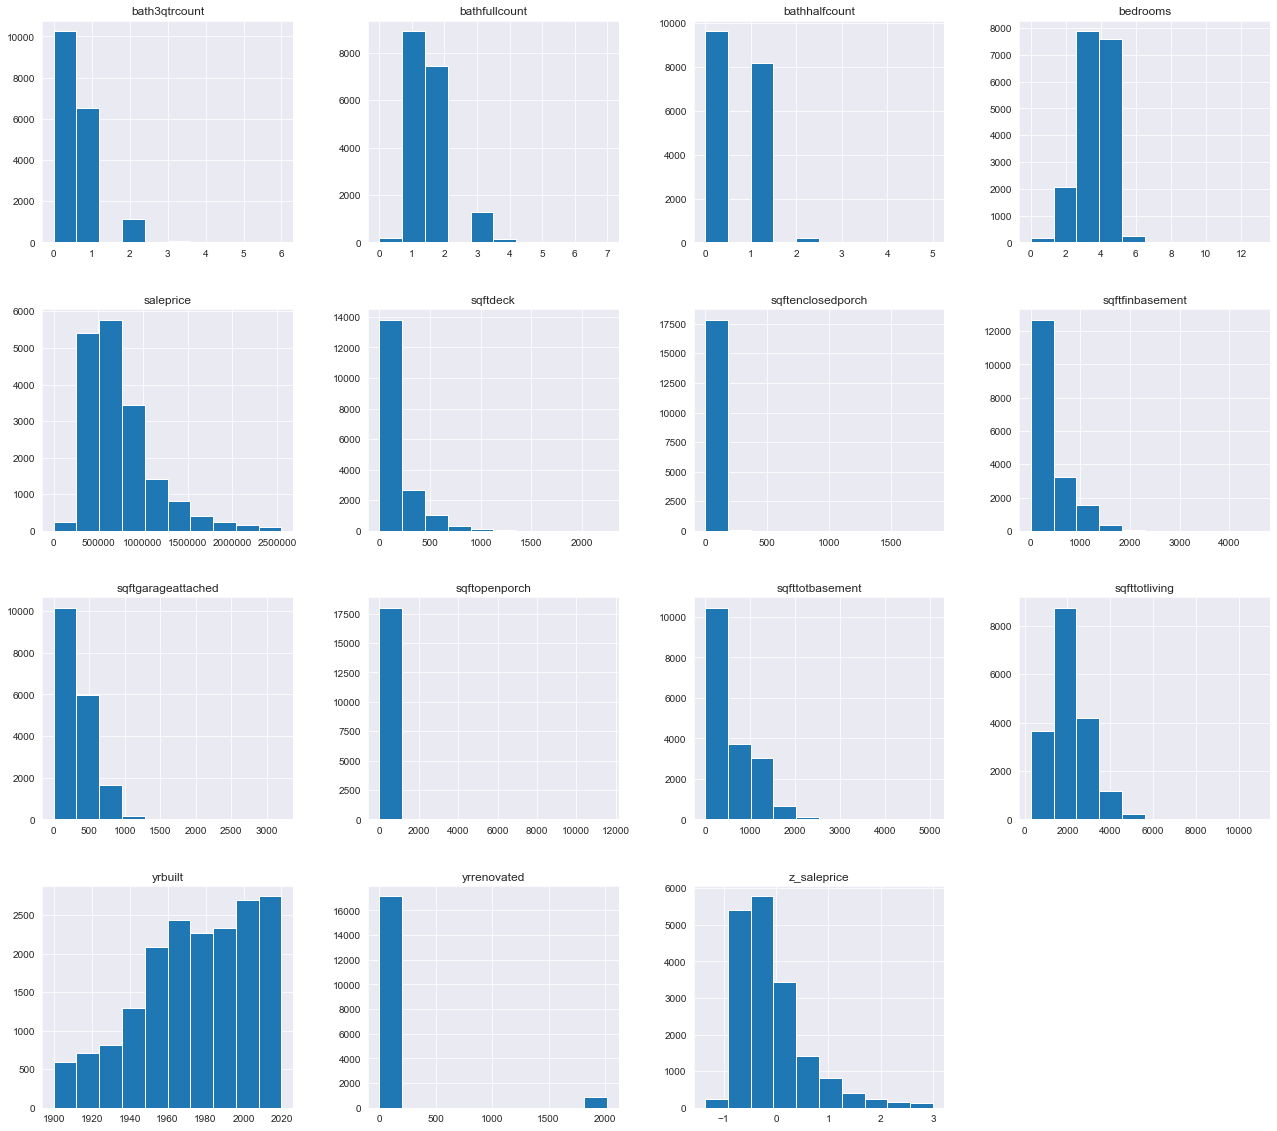

In [46]:
df.hist(figsize = (22, 20));

Correlations:

In [48]:
corr1 = df.corr()
corr1

,saleprice,sqfttotliving,yrbuilt,yrrenovated,bedrooms,sqfttotbasement,sqftfinbasement,sqftopenporch,sqftenclosedporch,sqftdeck,bathhalfcount,bath3qtrcount,bathfullcount,sqftgarageattached,z_saleprice
saleprice,1.000000,0.636020,0.095832,0.102641,0.316679,0.243885,0.255762,0.239205,0.013716,0.216612,0.198527,0.197418,0.350102,0.168460,1.000000
sqfttotliving,0.636020,1.000000,0.348099,0.034791,0.625069,0.272973,0.386867,0.323307,-0.003961,0.227035,0.332391,0.226988,0.561676,0.456837,0.636020
yrbuilt,0.095832,0.348099,1.000000,-0.250835,0.198852,-0.238588,-0.125384,0.144286,-0.081098,0.040852,0.393853,0.039481,0.398982,0.428052,0.095832
yrrenovated,0.102641,0.034791,-0.250835,1.000000,0.011236,0.062340,0.079896,0.016072,0.019389,0.052740,-0.064484,0.041398,0.030856,-0.097203,0.102641
bedrooms,0.316679,0.625069,0.198852,0.011236,1.000000,0.210262,0.289720,0.157804,-0.017228,0.090695,0.165679,0.203694,0.429374,0.276520,0.316679
sqfttotbasement,0.243885,0.272973,-0.238588,0.062340,0.210262,1.000000,0.848621,-0.040744,0.015085,0.259692,-0.088194,0.274326,0.032812,-0.358126,0.243885
sqftfinbasement,0.255762,0.386867,-0.125384,0.079896,0.289720,0.848621,1.000000,-0.020258,0.005890,0.283568,-0.053901,0.303358,0.105790,-0.193145,0.255762
sqftopenporch,0.239205,0.323307,0.144286,0.016072,0.157804,-0.040744,-0.020258,1.000000,-0.008582,-0.025175,0.118187,0.046555,0.199013,0.191682,0.239205
sqftenclosedporch,0.013716,-0.003961,-0.081098,0.019389,-0.017228,0.015085,0.005890,-0.008582,1.000000,0.013949,-0.019766,0.007266,-0.023423,-0.032521,0.013716
sqftdeck,0.216612,0.227035,0.040852,0.052740,0.090695,0.259692,0.283568,-0.025175,0.013949,1.000000,0.052074,0.163200,0.056569,0.014679,0.216612


Text(0.5, 1, 'Heat Map of Feature Correlations')

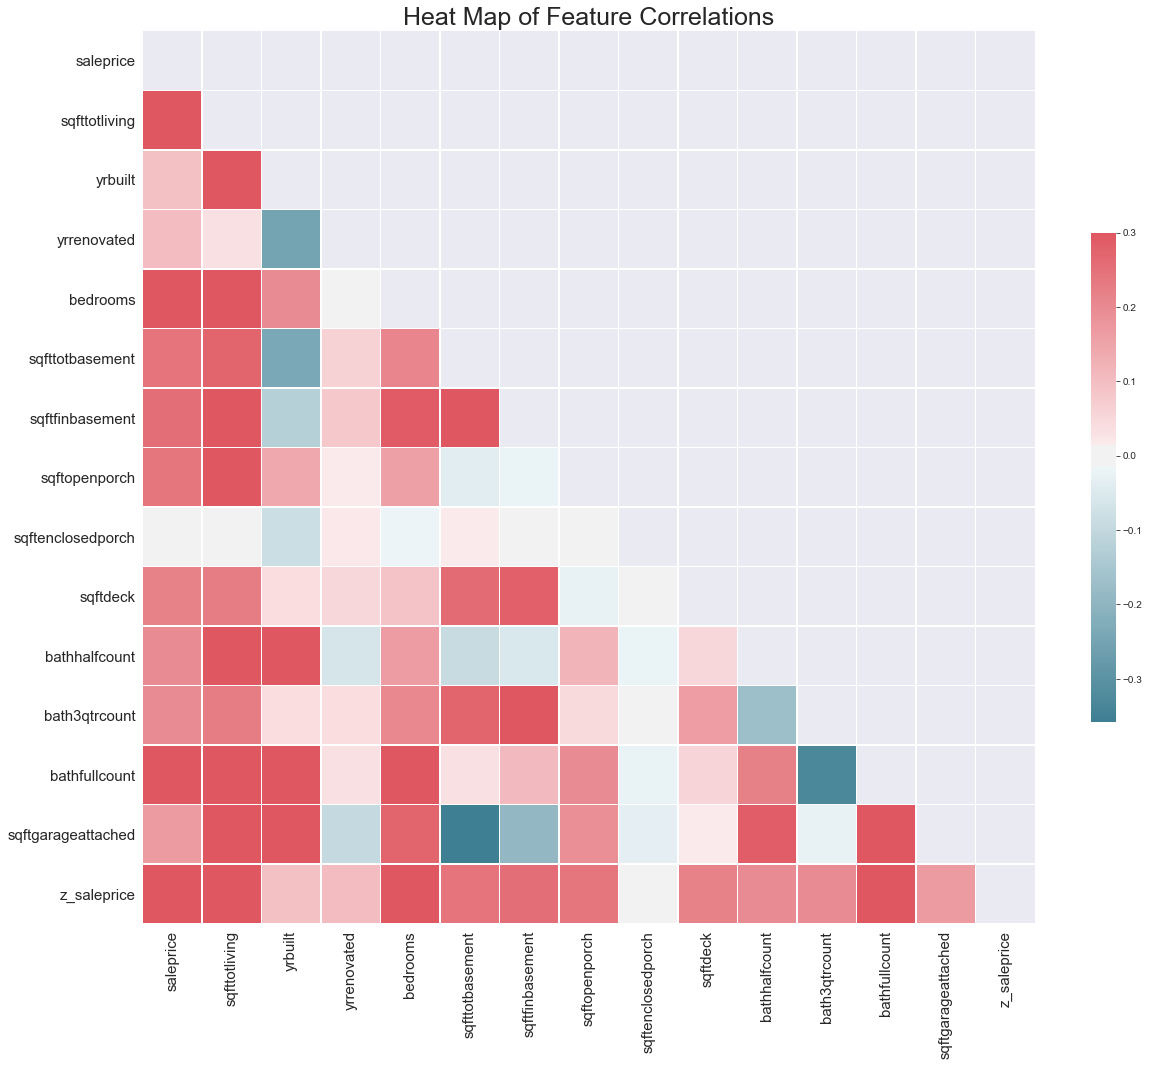

In [54]:
mask = np.triu(np.ones_like(corr1, dtype=np.bool))
f, ax = plt.subplots(figsize = (20, 18))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr1, mask = mask, cmap = cmap, vmax = 0.3, 
            center = 0, square = True, linewidths = 0.5, 
            cbar_kws = {'shrink': 0.5})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Heat Map of Feature Correlations', fontsize = 25)

### Model attempt 2:

The model above showed ALL our data.  Let's now look at which values have high correlations with `saleprice`:


In [59]:
# create df of correlated values
data_corrs = df.corr()

# inspect all the correlations with 'saleprice' in descedning order so we can see highest correlations
sorted_corrs = data_corrs['saleprice'].sort_values(ascending = False)
sorted_corrs

saleprice             1.000000
z_saleprice           1.000000
sqfttotliving         0.636020
bathfullcount         0.350102
bedrooms              0.316679
sqftfinbasement       0.255762
sqfttotbasement       0.243885
sqftopenporch         0.239205
sqftdeck              0.216612
bathhalfcount         0.198527
bath3qtrcount         0.197418
sqftgarageattached    0.168460
yrrenovated           0.102641
yrbuilt               0.095832
sqftenclosedporch     0.013716
Name: saleprice, dtype: float64

So let's just take features which have a correlation with the target of more than 0.1:

In [65]:
high_corrs = sorted_corrs[sorted_corrs > 0.1]
high_corrs

saleprice             1.000000
z_saleprice           1.000000
sqfttotliving         0.636020
bathfullcount         0.350102
bedrooms              0.316679
sqftfinbasement       0.255762
sqfttotbasement       0.243885
sqftopenporch         0.239205
sqftdeck              0.216612
bathhalfcount         0.198527
bath3qtrcount         0.197418
sqftgarageattached    0.168460
yrrenovated           0.102641
Name: saleprice, dtype: float64

In [66]:
# create df which just these vals
df_high_corrs = df.loc[:, ['saleprice', 'sqfttotliving', 'bedrooms', 'sqftfinbasement', 'sqfttotbasement', 
                           'sqftopenporch', 'sqftdeck', 'bath3qtrcount', 'sqftgarageattached', 'yrrenovated', 
                           'bathfullcount', 'bathhalfcount']]
df_high_corrs

,saleprice,sqfttotliving,bedrooms,sqftfinbasement,sqfttotbasement,sqftopenporch,sqftdeck,bath3qtrcount,sqftgarageattached,yrrenovated,bathfullcount,bathhalfcount
0,1910000,3990,6,1360,1360,110,1070,0,0,2019,4,1
1,1089950,3920,5,930,930,550,0,1,530,0,2,1
2,412500,2280,4,1140,1140,0,0,1,390,0,1,0
3,541000,1030,3,0,0,210,0,0,500,0,1,1
4,1020000,2410,3,1070,1070,0,170,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18288,1201000,3680,5,0,0,50,1000,0,530,0,2,2
18289,921000,2280,3,0,0,110,0,0,440,0,2,1
18290,627000,3820,5,0,0,80,0,1,420,0,1,1
18291,640000,2450,4,0,0,50,0,0,440,0,2,1


Get a sense of this data visually with a pairplot:

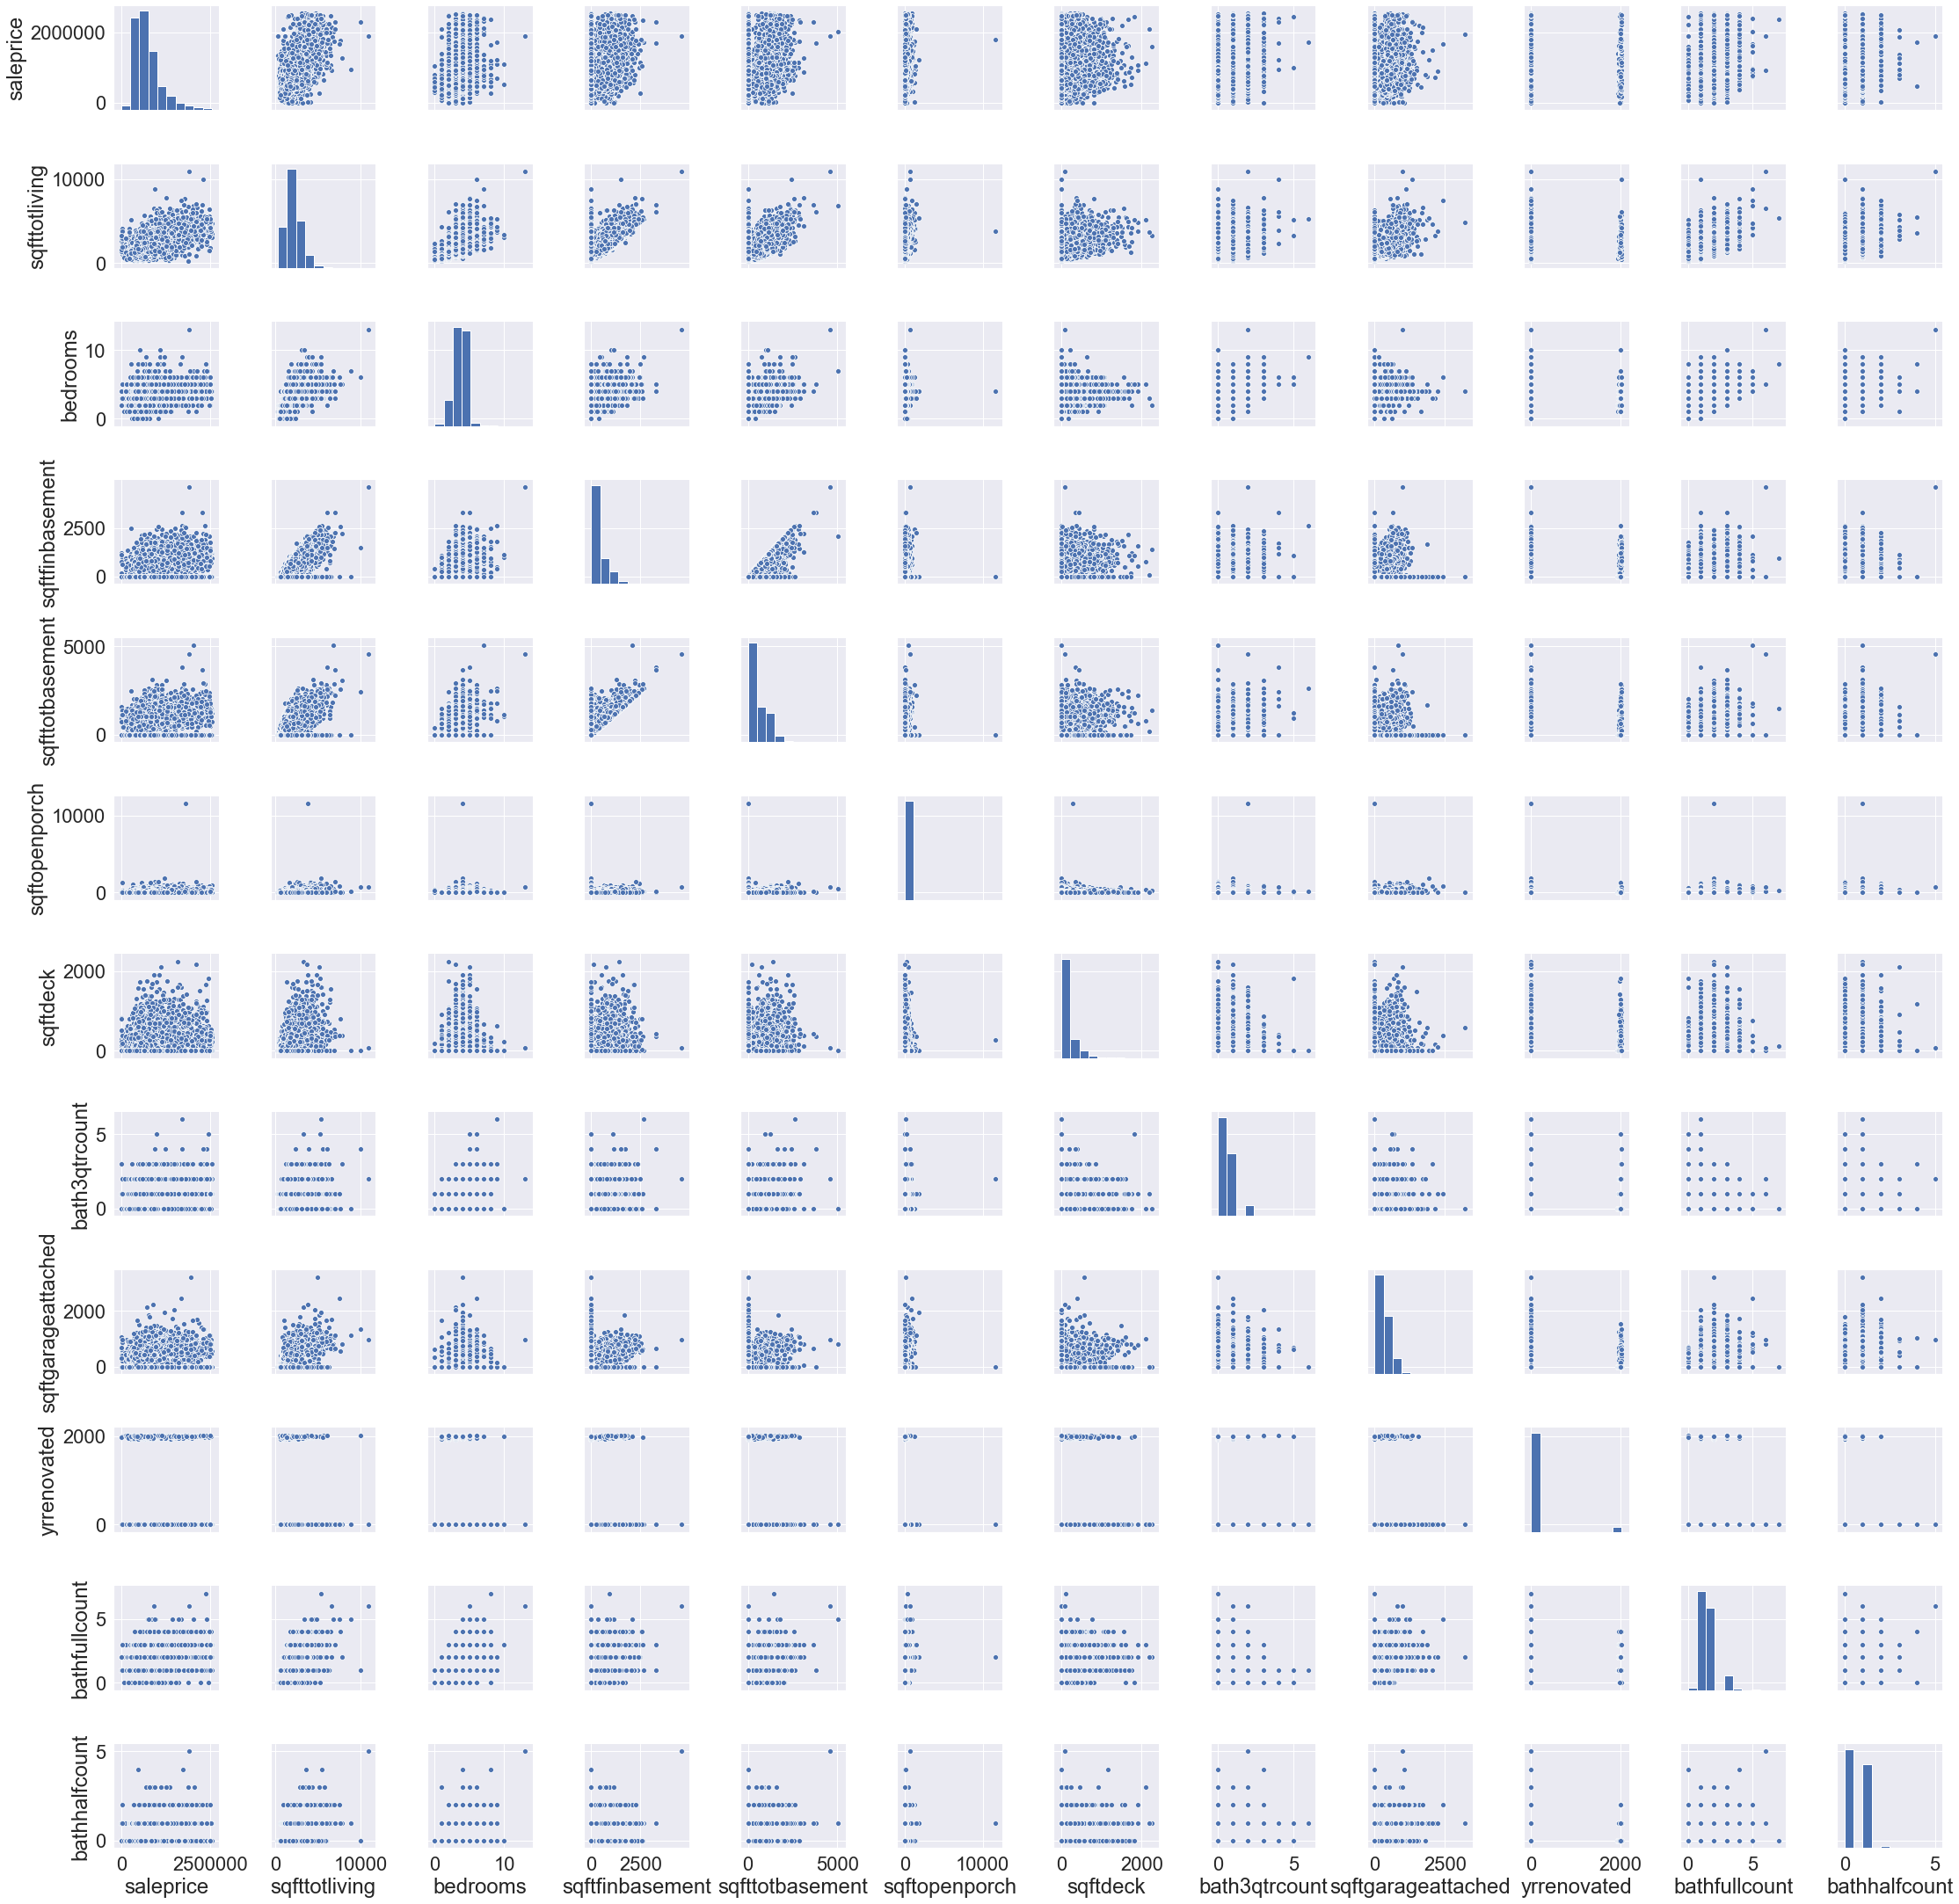

In [81]:
sns.pairplot(df_high_corrs);
sns.set(font_scale = 2)

In [67]:
# create x, y variables to work with
X = df_high_corrs.drop('saleprice', axis = 1)
y = df['saleprice']

Let's look again at how our independant variables are correlated:

In [68]:
corr_x = X.corr()
corr_x

,sqfttotliving,bedrooms,sqftfinbasement,sqfttotbasement,sqftopenporch,sqftdeck,bath3qtrcount,sqftgarageattached,yrrenovated,bathfullcount,bathhalfcount
sqfttotliving,1.000000,0.625069,0.386867,0.272973,0.323307,0.227035,0.226988,0.456837,0.034791,0.561676,0.332391
bedrooms,0.625069,1.000000,0.289720,0.210262,0.157804,0.090695,0.203694,0.276520,0.011236,0.429374,0.165679
sqftfinbasement,0.386867,0.289720,1.000000,0.848621,-0.020258,0.283568,0.303358,-0.193145,0.079896,0.105790,-0.053901
sqfttotbasement,0.272973,0.210262,0.848621,1.000000,-0.040744,0.259692,0.274326,-0.358126,0.062340,0.032812,-0.088194
sqftopenporch,0.323307,0.157804,-0.020258,-0.040744,1.000000,-0.025175,0.046555,0.191682,0.016072,0.199013,0.118187
sqftdeck,0.227035,0.090695,0.283568,0.259692,-0.025175,1.000000,0.163200,0.014679,0.052740,0.056569,0.052074
bath3qtrcount,0.226988,0.203694,0.303358,0.274326,0.046555,0.163200,1.000000,-0.027024,0.041398,-0.331722,-0.171518
sqftgarageattached,0.456837,0.276520,-0.193145,-0.358126,0.191682,0.014679,-0.027024,1.000000,-0.097203,0.322564,0.286841
yrrenovated,0.034791,0.011236,0.079896,0.062340,0.016072,0.052740,0.041398,-0.097203,1.000000,0.030856,-0.064484
bathfullcount,0.561676,0.429374,0.105790,0.032812,0.199013,0.056569,-0.331722,0.322564,0.030856,1.000000,0.218704


In [71]:
outcome = 'saleprice'
x_cols = list(X.columns)

In [72]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     1365.
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:19:04   Log-Likelihood:            -2.5171e+05
No. Observations:               17990   AIC:                         5.034e+05
Df Residuals:                   17978   BIC:                         5.035e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.032e+05   8968.010     22.659      0.000    1.86e+05    2.21e+05
sqfttotliving        316.0398      4.709     67.113      0.000     306.810     325.270
bedrooms           -5.932e+04   3119.794    -19.014      0.000   -6.54e+04   -5.32e+04
sqftfinbasement     -163.8031      9.916    -16.519      0.000    -183.239    -144.367
sqfttotbasement       95.3540      7.851     12.146      0.000      79.966     110.743
sqftopenporch         95.5463     16.219      5.891      0.000      63.756     127.337
sqftdeck             114.2013     10.983     10.398      0.000      92.674     135.729
bath3qtrcount        5.56e+04   4536.565     12.257      0.000    4.67e+04    6.45e+04
sqftgarageattached  -187.5642     10.298    -18.214      0.000    -207.749    -167.380
yrrenovated           57.6483      5.105     11.293      0.000      47.643      67.654
bathfullcount       4.432e+04   4782.950      9.265      0.000    3.49e+04    5.37e+04
bathhalfcount       1.416e+04   4621.210      3.064      0.002    5101.258    2.32e+04
==============================================================================
Omnibus:                     2998.163   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8747.429
Skew:                           0.882   Prob(JB):                         0.00
Kurtosis:                       5.925   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpret:

While this is the worst model so far, it is the most thought out so I am going to run with this and check the assumptions just to practice checking the assumptions.  

## Assumptions:

### Linearity:

In [33]:
# check multicollinearity between independent variables

# check 1-1 linearity with target variable for each one (we can sort of get an idea of this from plots above).  
# p-vals also signify this although R^2 is low so kinda not.

### Normality:

Text(0.5, 1.0, 'QQ-Plot of Residuals')

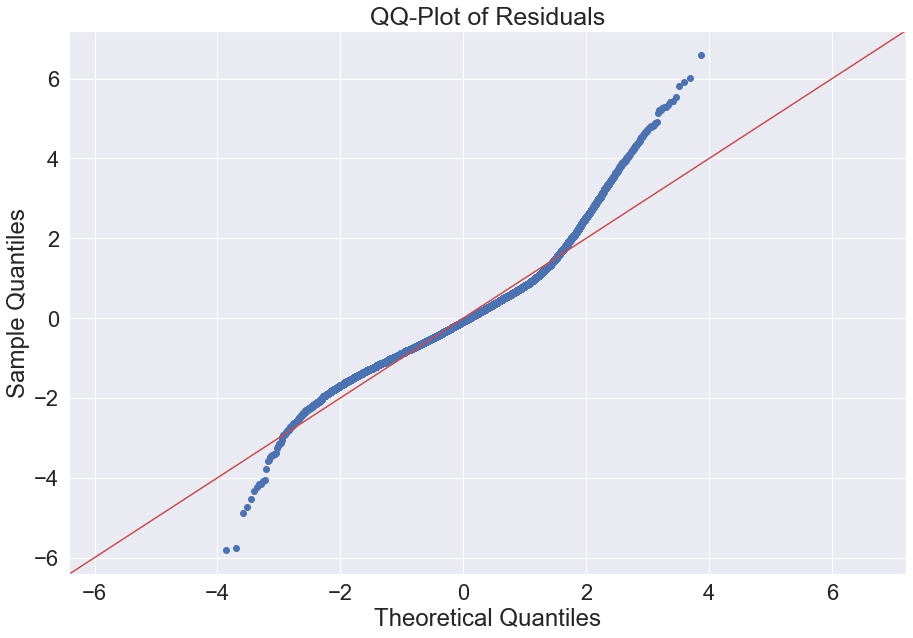

In [83]:
fig, ax = plt.subplots(figsize = (15, 10))
figure = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax = ax)
ax.set_title('QQ-Plot of Residuals', fontsize = 25)

From the plot above, the residuals do not look normal as can be seen by the significant curvature away from the straight line. 

### Homoscadasicity:

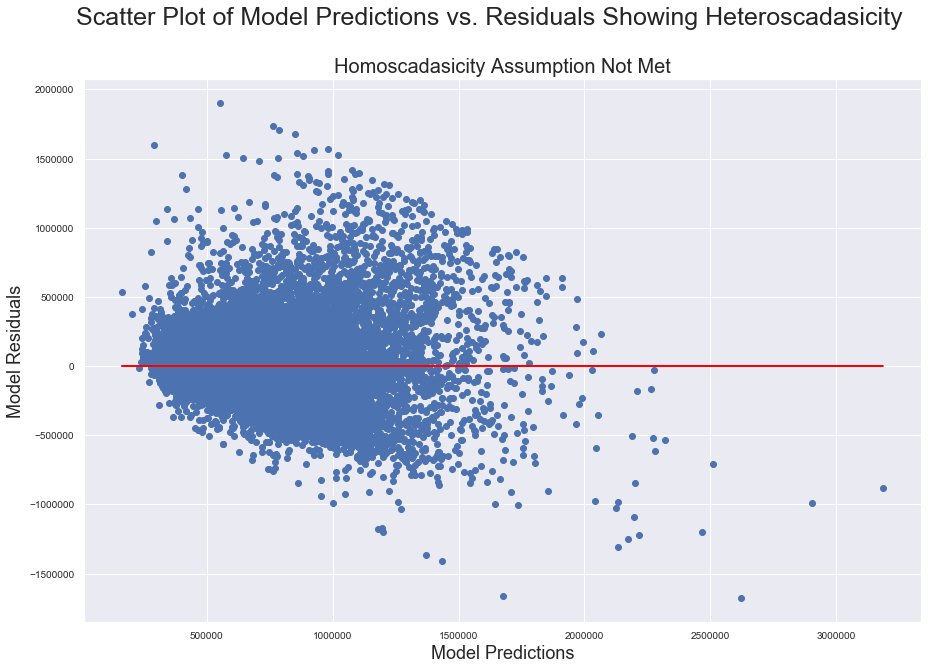

In [109]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model.predict(), model.resid)
sns.set(font_scale = 1)
fig.suptitle('Scatter Plot of Model Predictions vs. Residuals Showing Heteroscadasicity', fontsize = 25)
ax.set_title('Homoscadasicity Assumption Not Met', fontsize = 20)
plt.xlabel('Model Predictions', fontsize = 18)
plt.ylabel('Model Residuals', fontsize = 18)
ax.tick_params(labelsize=10)
plt.plot(model.predict(), [0 for i in range(len(df))], color = 'red')

We can see here that the residuals are clustered around a particular region around y = 0 and x = [480000, 1200000].  There is not much randomness of the residuals and so the homoscadasicity assumption is not met.   